 # Deep Learning Project : Age & Gender Image Prediction
- The goal of this project is to use Deep Learning to predict the age & gender of a person with a picture. Which is a difficult task even for a human (specially for age) 


# Data Set Information :
- UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.
- More info here : https://susanqq.github.io/UTKFace/

# 0. Import & Configure GPU

In [4]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
#display tensorflow & keras version to ensure compatibility
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.10.0
Keras version: 2.10.0


# 1. Exploratory Data Analysis

In [ ]:
# Initialize an empty array to store ages
ages = []

# Extract ages from file names in the 'UTKFace' directory
for i in os.listdir('UTKFace'):
    split = i.split('_') #Extract age from the file name and append it to the 'ages' array
    ages.append(int(split[0]))

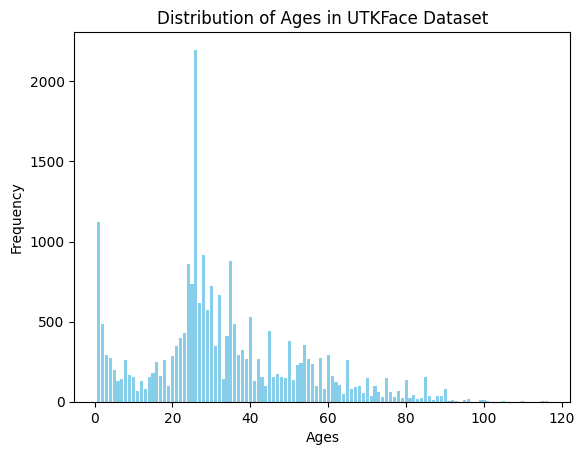

In [13]:
# Get the unique values and their counts
unique_values, counts = np.unique(ages, return_counts=True)

# Plot the distribution
plt.bar(unique_values, counts, color='skyblue')
plt.title('Distribution of Ages in UTKFace Dataset')
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.show()

## 1.1 Import image info to a Data Frame

In [18]:
# Directory containing the images
image_dir = 'UTKFace'

# Function to parse age and sex from file names
def parse_age_and_sex(filename):
    parts = filename.split('_')
    age = int(parts[0])
    sex = int(parts[1])
    return age, sex

In [19]:
# Create a DataFrame with file paths, ages, and sexes
file_paths = []
ages = []
sexes = []

for filename in os.listdir(image_dir):
    file_path = os.path.join(image_dir, filename)
    age, sex = parse_age_and_sex(filename)
    file_paths.append(file_path)
    ages.append(age)
    sexes.append(sex)

In [20]:
# Organize DataFrame columns and display the first few rows
df = pd.DataFrame({'path': file_paths, 'age': ages, 'sex': sexes})
df.head()

,path,age,sex
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100,0
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100,0
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100,1
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100,1
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100,1


## 1.3 Gender distribution

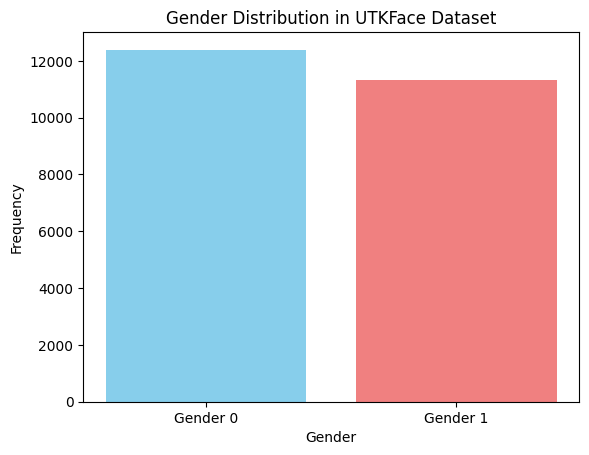

In [21]:
# Count the occurrences of each gender
gender_counts = df['sex'].value_counts()

# Plot the gender distribution
plt.bar(gender_counts.index, gender_counts, color=['skyblue', 'lightcoral'])
plt.xticks(gender_counts.index, ['Gender 0', 'Gender 1'])
plt.title('Gender Distribution in UTKFace Dataset')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

## 1.4 Age distribution

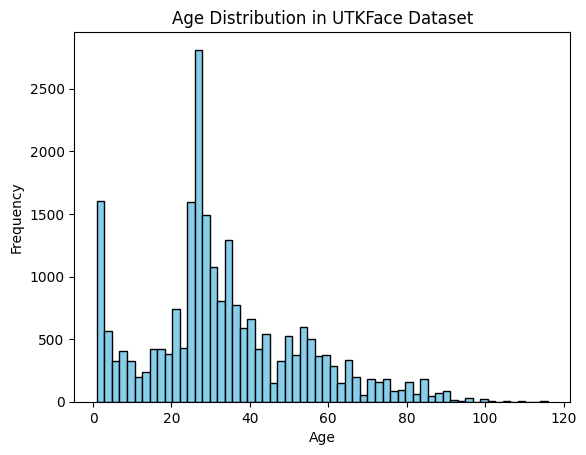

In [26]:
# Plot the age distribution
plt.hist(df['age'], bins=60, color='skyblue', edgecolor='black')
plt.title('Age Distribution in UTKFace Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## 1.5 Display Images

In [28]:
#define a function to display images
def display_images(file_paths):
    num_images = len(file_paths)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    for i, file_path in enumerate(file_paths):
        # Load and display each image
        img = mpimg.imread(file_path)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

In [29]:
# Function to display images based on conditions
def display_images_with_conditions(df, target_age, target_sex):
    filtered_df = df[(df['age'] == target_age) & (df['sex'] == target_sex)]
    if filtered_df.empty:
        print(f"No images found for age={target_age} and sex={target_sex}.")
        return
    file_paths = filtered_df['path'].head(6)  # Display the first 6 images
    display_images(file_paths)

## 25 y/o Male

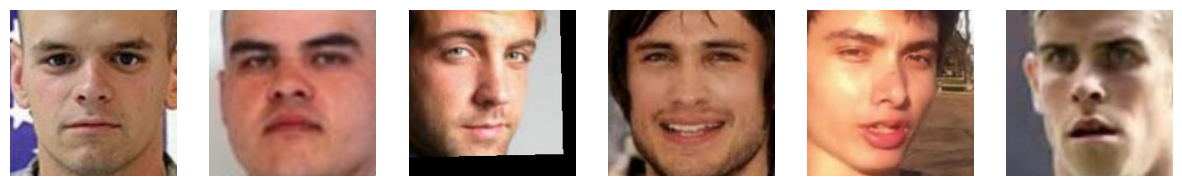

In [57]:
# Example: Display images where age=25 and sex=0
display_images_with_conditions(df, target_age=25, target_sex=0)

## 14 y/o Female

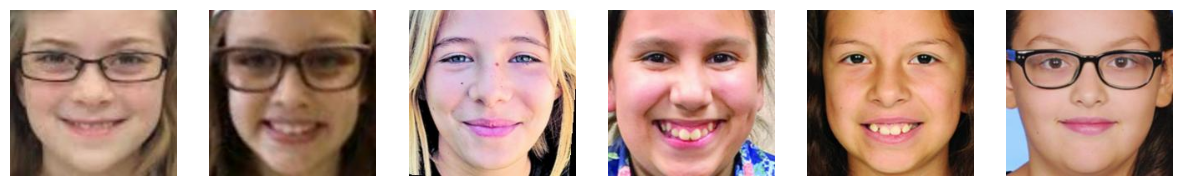

In [41]:
# Example: Display images where age=14 and sex=0
display_images_with_conditions(df, target_age=14, target_sex=1)

# 2. Pre-Processing

In [39]:
# 'path' column contains file paths of images / 'Ages' and 'Genders' are target variables
x_image_paths = df['path']
y_age = df['age']
y_gender = df['sex']

## 2.1 Split train/test for age & gender

In [42]:
# Split the dataset for age prediction
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x_image_paths, y_age, test_size=0.2, random_state=42)

# Split the dataset for gender prediction
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x_image_paths, y_gender, test_size=0.2, random_state=42)

## 2.2 Age & Gender distribution train/test

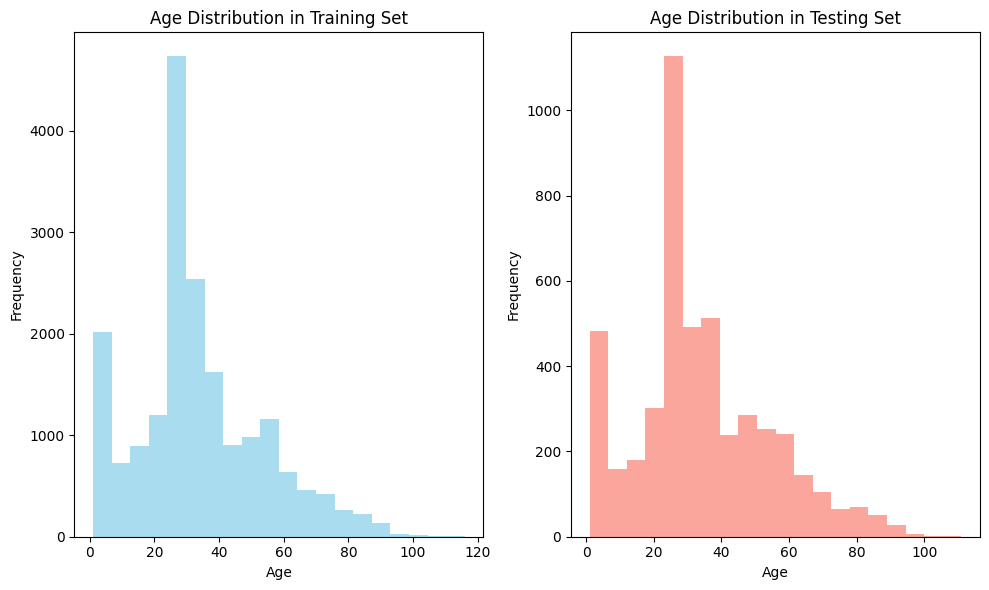

In [47]:
# Plot histograms for age distribution in training and testing sets
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train_age, bins=20, color='skyblue', alpha=0.7)
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_test_age, bins=20, color='salmon', alpha=0.7)
plt.title('Age Distribution in Testing Set')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

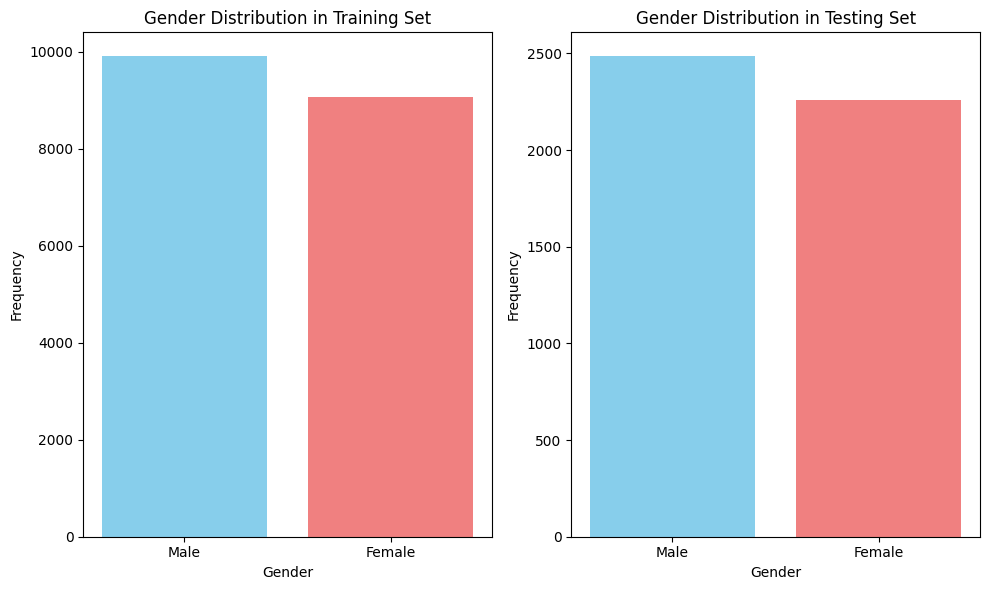

In [48]:
# Plot bar plots for y_train_gender and y_test_gender
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(['Male', 'Female'], y_train_gender.value_counts(), color=['skyblue', 'lightcoral'])
plt.title('Gender Distribution in Training Set')
plt.xlabel('Gender')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.bar(['Male', 'Female'], y_test_gender.value_counts(), color=['skyblue', 'lightcoral'])
plt.title('Gender Distribution in Testing Set')
plt.xlabel('Gender')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2.3 Image processing

In [49]:
#define image size 
IMG_SIZE=200

#### Age Set up
- For age prediction, an **ImageDataGenerator** is set up with various augmentation parameters. This generator is responsible for augmenting the training images to increase the model's robustness. Augmentation includes rotation, width and height shifts, shearing, zooming, and horizontal flipping.
- The **flow_from_dataframe** function is then used to create separate generators for the training and testing sets. Images are loaded from the specified paths, resized to IMG_SIZE, and their corresponding age labels are extracted.

In [70]:
# ImageDataGenerator for Age Training 
age_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set up flow_from_dataframe for age prediction
age_train_generator = age_datagen.flow_from_dataframe(
    dataframe=df.loc[x_train_age.index],  # Use the indices from x_train_age
    x_col='path',
    y_col='age',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='other',
    shuffle=True
)

In [66]:
# ImageDataGenerator for testing - Only rescaling
age_test_datagen = ImageDataGenerator(rescale=1./255)

# Set up flow_from_dataframe for age prediction - Testing
age_test_generator = age_test_datagen.flow_from_dataframe(
    dataframe=df.loc[x_test_age.index],
    x_col='path',
    y_col='age',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='other',
    shuffle=False  # No shuffling for the test set
)

Found 4742 validated image filenames.


#### 2. Gender Set up 
- Similar to age prediction, a separate **ImageDataGenerator** is created for gender prediction. 
- For gender prediction, where the task is typically a binary classification (e.g., male or female), data augmentation might not be as critical as it is for tasks like age prediction or object recognition. 
- The 'sex' column is converted to strings, indicating binary gender labels (0 for male, 1 for female).

In [69]:
# ImageDataGenerator for Training - Only rescaling
gender_datagen = ImageDataGenerator(rescale=1./255)

# Convert 'sex' column to strings
df['sex'] = df['sex'].astype(str)

# Set up flow_from_dataframe for gender prediction
gender_train_generator = gender_datagen.flow_from_dataframe(
    dataframe=df.loc[x_train_gender.index],  # Use the indices from x_train_gender
    x_col='path',
    y_col='sex',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 18966 validated image filenames belonging to 2 classes.


In [68]:
# ImageDataGenerator for testing - Only rescaling
gender_test_datagen = ImageDataGenerator(rescale=1./255)

# Set up flow_from_dataframe for gender prediction - Testing
gender_test_generator = gender_datagen.flow_from_dataframe(
    dataframe=df.loc[x_test_gender.index],
    x_col='path',
    y_col='sex',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # No shuffling for the test set
)


Found 4742 validated image filenames belonging to 2 classes.


These generators are crucial for efficiently feeding batches of preprocessed images and their corresponding labels into the deep learning model during training and evaluation. The augmentation in the training set helps prevent overfitting and improves the model's ability to generalize to unseen data.

# 3. Deep Learning Model

# 3.1 Age Model

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from keras.utils.layer_utils import get_source_inputs
from keras_vggface.vggface import VGGFace
from keras.regularizers import l2

In [72]:
# Load the VGGFace model with pre-trained weights
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')

- **VGGFace** is a pre-trained model specifically designed for face recognition tasks.
- **model='vgg16'** specifies that the VGG16 architecture should be used.
- **include_top=False** excludes the final fully connected layers of the original VGG16 model.
- **input_shape=(IMG_SIZE, IMG_SIZE, 3)** defines the input shape for the model.
- **pooling='avg'** specifies global average pooling for reducing spatial dimensions.

In [73]:
# Unfreeze the last few layers of the VGGFace model
for layer in base_model.layers[-3:]:
    layer.trainable = True

- This code unfreezes the last three layers of the VGGFace model, allowing them to be fine-tuned during training.

In [74]:
# Create a new model for age prediction
model = Sequential()
model.add(base_model)  # Assuming you have loaded your base_model
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))  

- The pre-trained **VGGFace** model is added as the base layer.
- Several fully connected layers (**Dense**) are added on top of the VGGFace model for age prediction.
- **Dropout** layers are included for regularization to prevent overfitting.

In [75]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the learning rate
learning_rate = 0.001

# Create the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')  # Use appropriate loss for regression

- The **Adam optimizer** is used with a specified learning rate.
- The model is compiled using mean squared error ('**mean_squared_error**') as the loss function. This is common for regression tasks, such as age prediction.

In [77]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [74]:
# Train the model
history_age = model.fit(age_train_generator, epochs=30, validation_data=age_test_generator)

Epoch 1/30
593/593 [==============================] - 177s 259ms/step - loss: 6171.6724 - val_loss: 305.3885
Epoch 2/30
593/593 [==============================] - 146s 247ms/step - loss: 300.8928 - val_loss: 273.1644
Epoch 3/30
593/593 [==============================] - 149s 251ms/step - loss: 213.9292 - val_loss: 206.2956
Epoch 4/30
593/593 [==============================] - 158s 266ms/step - loss: 191.1342 - val_loss: 173.2210
Epoch 5/30
593/593 [==============================] - 158s 266ms/step - loss: 168.1852 - val_loss: 117.5609
Epoch 6/30
593/593 [==============================] - 157s 264ms/step - loss: 157.7369 - val_loss: 136.5397
Epoch 7/30
593/593 [==============================] - 153s 258ms/step - loss: 146.1830 - val_loss: 133.5814
Epoch 8/30
593/593 [==============================] - 150s 253ms/step - loss: 148.6324 - val_loss: 117.9038
Epoch 9/30
593/593 [==============================] - 143s 241ms/step - loss: 138.3787 - val_loss: 121.1600
Epoch 10/30
593/593 [======

## 1. Evaluate metrics
## Loss curve

In [ ]:
fig = plt.figure()
plt.plot(history_age.history['loss'][1:], color='teal', label='loss')
plt.plot(history_age.history['val_loss'][1:], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 3.2 Gender Model

In [78]:
# Load the pre-trained VGGFace model
base_model_gender = VGGFace(model='vgg16', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')

# Make the last few layers trainable
for layer in base_model_gender.layers[-3:]:
    layer.trainable = True

# Build the gender prediction model
gender_model = Sequential()
gender_model.add(base_model_gender)
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(256, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(128, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification (0 or 1)

- A new model is created for gender prediction.
- Fully connected layers (**Dense**) are added on top of the VGGFace model for gender classification.
- The final activation is **'sigmoid'** since it's a binary classification task (0 or 1).

In [81]:
# Define the learning rate
learning_rate_gender  = 0.0001

# Create the Adam optimizer with the specified learning rate
optimizer_gender = Adam(learning_rate=learning_rate_gender)

# Compile the gender model
gender_model.compile(optimizer=optimizer_gender, loss='binary_crossentropy', metrics=['accuracy'])

- The Adam optimizer is used with a specified learning rate.
- Binary crossentropy is used as the loss function, appropriate for binary classification.
- Accuracy is monitored as a metric during training.

In [80]:
# Display the model summary
gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 512)               14714688  
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [83]:
# Train the gender model
history_gender = gender_model.fit(gender_train_generator, epochs=25, validation_data=gender_test_generator)

Epoch 1/25
593/593 [==============================] - 203s 317ms/step - loss: 0.3939 - accuracy: 0.8091 - val_loss: 0.2651 - val_accuracy: 0.8903
Epoch 2/25
593/593 [==============================] - 176s 297ms/step - loss: 0.2355 - accuracy: 0.9082 - val_loss: 0.2343 - val_accuracy: 0.9093
Epoch 3/25
593/593 [==============================] - 176s 297ms/step - loss: 0.1907 - accuracy: 0.9267 - val_loss: 0.2817 - val_accuracy: 0.9007
Epoch 4/25
593/593 [==============================] - 176s 296ms/step - loss: 0.1577 - accuracy: 0.9418 - val_loss: 0.2506 - val_accuracy: 0.9216
Epoch 5/25
593/593 [==============================] - 176s 296ms/step - loss: 0.1300 - accuracy: 0.9532 - val_loss: 0.2220 - val_accuracy: 0.9207
Epoch 6/25
593/593 [==============================] - 175s 295ms/step - loss: 0.1079 - accuracy: 0.9620 - val_loss: 0.1921 - val_accuracy: 0.9222
Epoch 7/25
593/593 [==============================] - 175s 294ms/step - loss: 0.0867 - accuracy: 0.9692 - val_loss: 0.2919 -

## Loss curve

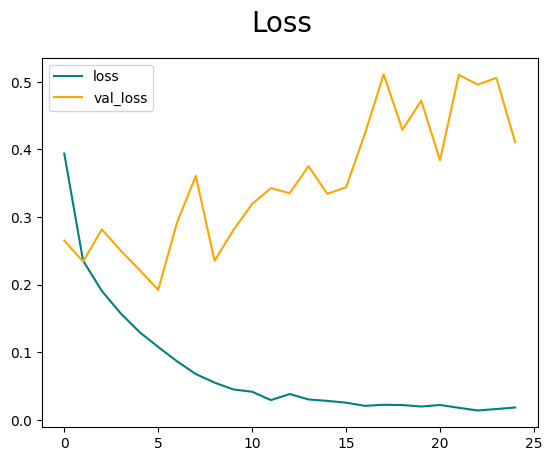

In [85]:
fig = plt.figure()
plt.plot(history_gender.history['loss'], color='teal', label='loss')
plt.plot(history_gender.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Accuracy curve

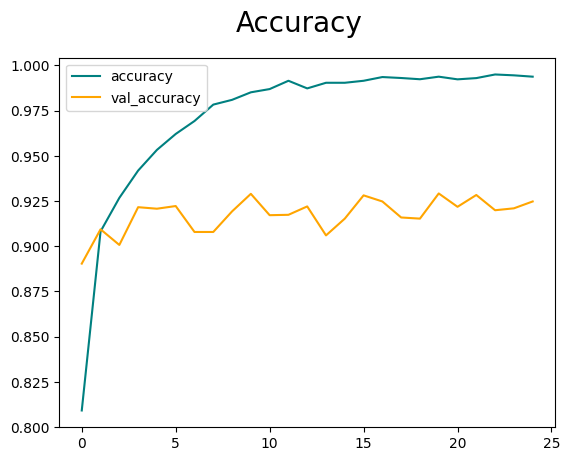

In [86]:
fig = plt.figure()
plt.plot(history_gender.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_gender.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Save Models

### 4.1 Age Model

In [ ]:
#save model
model.save('age_model.h5')

In [86]:
#load model to check if it have been saved correctly
age_model = load_model('age_model.h5')

### 4.2 Gender Model

In [84]:
#save model
gender_model.save('gender_model.h5')

In [87]:
#load model to check if it have been saved correctly
gender_model=load_model('gender_model.h5')

# 5. Testing Model

In [89]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import cv2
import dlib

def process_and_predict(file, box_expansion=0.07, margin=1):
    im = Image.open(file)
    # Convert PIL image to OpenCV format (BGR)
    cv_image = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

    # Create the Dlib face detector
    detector = dlib.get_frontal_face_detector()

    # Detect faces in the image
    faces = detector(cv_image)

    if faces:
        # Use the first detected face for simplicity
        face_rect = faces[0]

        # Convert Dlib rectangle to (x, y, w, h)
        x, y, w, h = face_rect.left(), face_rect.top(), face_rect.width(), face_rect.height()

        # Expand the bounding box
        expansion_x = int(w * box_expansion)
        expansion_y = int(h * box_expansion)
        x -= expansion_x
        y -= expansion_y
        w += 2 * expansion_x
        h += 2 * expansion_y

        # Add margin
        x -= margin
        y -= margin
        w += 2 * margin
        h += 2 * margin

        # Ensure the expanded box is within the image boundaries
        x = max(0, x)
        y = max(0, y)
        w = min(cv_image.shape[1] - x, w)
        h = min(cv_image.shape[0] - y, h)

        # Crop and zoom on the expanded face
        face = cv_image[y:y+h, x:x+w]

        # Resize the face to 200x200
        face = cv2.resize(face, (200, 200))

        # Convert the NumPy array back to PIL image
        im = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    else:
        # If no face is detected, resize the entire image to 200x200
        im = im.resize((200, 200), resample=Image.BICUBIC)

    # Convert the PIL image to a NumPy array
    ar = np.asarray(im)

    # Convert the data type of the array to float32
    ar = ar.astype('float32')

    # Normalize the pixel values to the range [0, 1]
    ar /= 255.0

    # Reshape the array to match the expected input shape of the model
    ar = ar.reshape(-1, 200, 200, 3)

    # Predict age and gender using the provided models
    age = age_model.predict(ar)
    gender = np.round(gender_model.predict(ar))

    # Convert gender prediction to 'male' or 'female'
    gender = 'male' if gender == 0 else 'female'

    # Print the predicted age and gender
    print('Age:', int(age), '\nGender:', gender)

    # Return the resized image (300x300)
    return im.resize((300, 300), Image.BICUBIC)

The **process_and_predict** function takes an image file as input and performs the following steps:

1. Opens the image file and converts it to OpenCV format (BGR).
2. Utilizes the dlib face detector to identify faces in the image.
3. If a face is detected:
    - Expands the bounding box around the face.
    - Resizes the face to 200x200 pixels.

4. If no face is detected:
    - Resizes the entire image to 200x200 pixels.
5. Converts the processed image to a NumPy array, normalizes pixel values, and reshapes it to match the expected input shape.
6. Uses pre-trained models for age and gender prediction:
    - Predicts the age using the age_model.
    - Predicts the gender and converts the prediction to 'male' or 'female' using the gender_model.
7. Prints the predicted age and gender.
8. Returns the resized image (300x300 pixels).

To use this function, provide the path to your pre-trained age and gender models (age_model and gender_model), and call the function with the image file you want to analyze.

## 5.1 Test on specific images

# 1. 1yo

1/1 [==============================] - 0s 19ms/step
Age: 1 
Gender: female


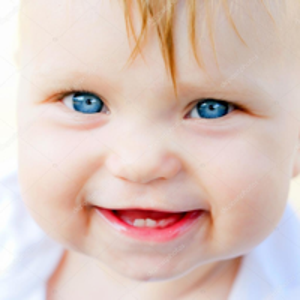

In [90]:
# Example usage:
img_path = "test_images/1yo.jpg"  
process_and_predict(img_path)

# 2. 8yo

1/1 [==============================] - 0s 18ms/step
Age: 4 
Gender: female


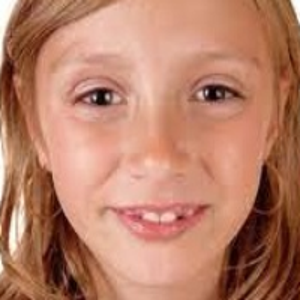

In [91]:
# Example usage:
img_path = "test_images/8yo.jpg"  
process_and_predict(img_path)

# 3. 16yo

1/1 [==============================] - 0s 19ms/step
Age: 23 
Gender: female


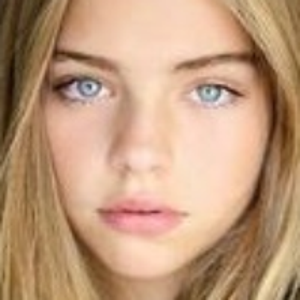

In [92]:
# Example usage:
img_path = "test_images/16yo.jpg"  
process_and_predict(img_path)

# 4. 20yo

1/1 [==============================] - 0s 18ms/step
Age: 21 
Gender: female


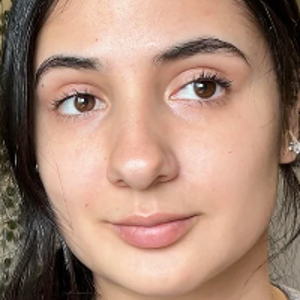

In [97]:
# Example usage:
img_path = "test_images/20yo.jpg"  
process_and_predict(img_path)

# 5. 25 yo

1/1 [==============================] - 0s 17ms/step
Age: 29 
Gender: male


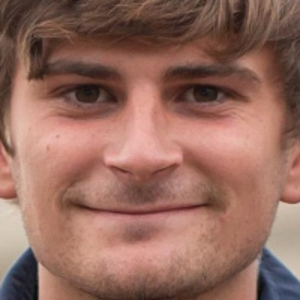

In [93]:
# Example usage:
img_path = "test_images/25yo.jpg"  

process_and_predict(img_path)

# 6. 40yo

1/1 [==============================] - 0s 19ms/step
Age: 51 
Gender: male


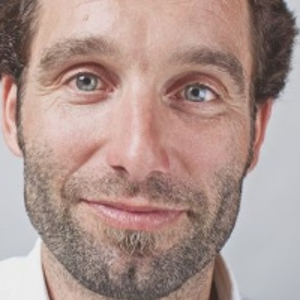

In [95]:
# Example usage:
img_path = "test_images/40yo.jpg"  

process_and_predict(img_path)

# 7. 38yo

1/1 [==============================] - 0s 18ms/step
Age: 44 
Gender: male


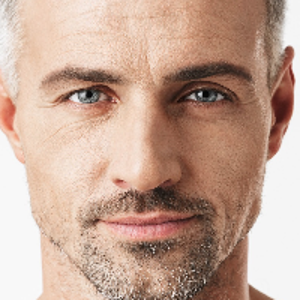

In [96]:
# Example usage:
img_path = "test_images/38yo.jpg"  
process_and_predict(img_path)

# 8. 55yo

1/1 [==============================] - 0s 17ms/step
Age: 75 
Gender: female


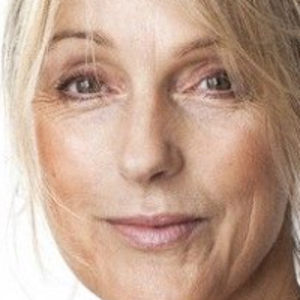

In [99]:
# Example usage:
img_path = "test_images/55yo.jpg"  
process_and_predict(img_path)

# 9. 70yo

1/1 [==============================] - 0s 19ms/step
Age: 81 
Gender: female


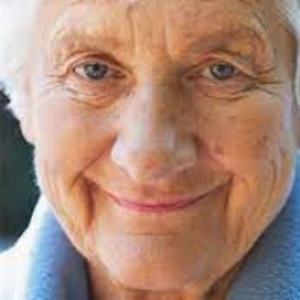

In [100]:
# Example usage:
img_path = "test_images/70yo.jpg"  
process_and_predict(img_path)

# Man Makeup

1/1 [==============================] - 0s 19ms/step
Age: 21 
Gender: male


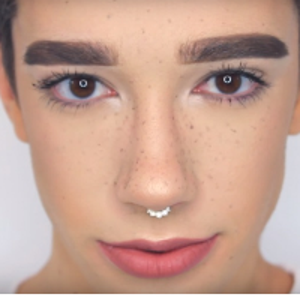

In [101]:
# Example usage:
img_path = "test_images/makeupman.jpg"  
process_and_predict(img_path)

# Model Woman

1/1 [==============================] - 0s 21ms/step
Age: 21 
Gender: female


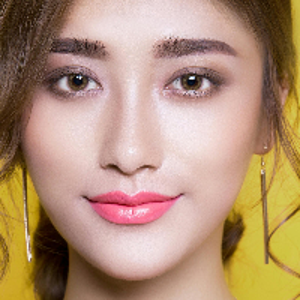

In [102]:
# Example usage:
img_path = "test_images/model1.jpg"  
process_and_predict(img_path)

# Modele Woman 2

1/1 [==============================] - 0s 20ms/step
Age: 15 
Gender: female


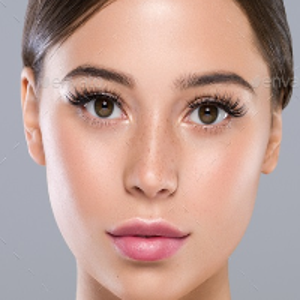

In [103]:
# Example usage:
img_path = "test_images/model2.jpg"  
process_and_predict(img_path)

# Fail example

1/1 [==============================] - 0s 18ms/step
Age: 8 
Gender: female


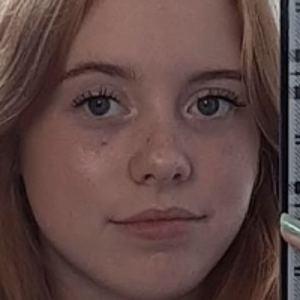

In [104]:
# Example usage:
img_path = "test_images/fail1.jpg"  
process_and_predict(img_path)